## to do:

1. do custom windows: 40, 80 and 120 test. Loop ad compare

In [1]:
!pip install wandb

     |████████████████████████████████| 1.7 MB 4.1 MB/s 
     |████████████████████████████████| 97 kB 6.3 MB/s 
     |████████████████████████████████| 180 kB 52.9 MB/s 
     |████████████████████████████████| 139 kB 52.2 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=9a8930b635b117ccc6dacfc5f5503c67014e58900224299a8b9e9d3c9cd8428b
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=14a3890665097443f4b722279b991edd4c33b3bc209479f46a85b62b304acd46
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools


ref: https://github.com/chaoshangcs/GTS

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/PhD/MLCollective/graphbatt/GTS
!ls

/content/drive/MyDrive/PhD/MLCollective/graphbatt/GTS
'1. gts-graphbatt-train.ipynb'
'2. gts-graphbatt-benchmarking.ipynb'
'4b. monteCarlo-gts-gaets-benchmarkData-train-evaluate.ipynb'
'4c. all-monteCarlo-gts-gaets-graphbatt-train-evaluate.ipynb'
'4. monteCarlo-gts-gaets-graphbatt-train-evaluate.ipynb'
'5. loop-CustomWindow-monteCarlo-gts-gaets-graphbatt-train-evaluate.ipynb'
 data
 gts-debug.ipynb
 lib
 LICENSE
 model
 models
 pytorch-geometric-temporal.ipynb
 README.md
 requirements.txt
 runs
 scripts
 train.py
 wandb


In [4]:
import argparse
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
import os
import re

import torch

from tqdm.notebook import tqdm
import networkx as nx

class DummyTrainArgs():
  def __init__(self, config_filename, use_cpu_only, temperature):
    self.config_filename = config_filename
    self.use_cpu_only = use_cpu_only
    self.temperature = temperature

import argparse
import yaml
from importlib import reload
import model
reload(model)
from model.pytorch.supervisor import GTSSupervisor, GAETSSupervisor
from lib.utils import load_graph_data
import torch

import scripts.eval_baseline_methods

import argparse
import numpy as np
import pandas as pd

from statsmodels.tsa.vector_ar.var_model import VAR

# from lib import utils
from lib.metrics import masked_rmse_np, masked_mape_np, masked_mae_np
from lib.utils import StandardScaler

from tqdm.notebook import tqdm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
""" LOAD FROM DIFFERENT FILES """
import numpy as np
from lib.utils import DataLoader

# load test dataset
def create_test_iterator(supervisor, supervisor_config, test_dataset_dir = "data/graphbatt/test"):
  data = {}
  category = 'test'
  cat_data = np.load(os.path.join(test_dataset_dir, category + '.npz'))
  _x = cat_data['x']
  _y = cat_data['y']
  # use scaler from supervisor trained's scaler
  scaler = supervisor.train_scaler
  _x[..., 0] = scaler.transform(_x[..., 0])
  _y[..., 0] = scaler.transform(_y[..., 0])
  test_loader = DataLoader(_x, _y, supervisor_config["data"]["test_batch_size"], shuffle=False)

  return test_loader.get_iterator()

## monte carlo sweep

In [7]:
""" Create Train Dataset """
train_df = pd.read_excel("data/graphbatt/DOE-001-050-10DU_05.xlsx", sheet_name="Channel_81_1")
train_df = train_df.iloc[:2257]
train_df.set_index("Date_Time", inplace=True)
train_df[["Voltage(V)", "Current(A)", "Charge_Capacity(Ah)", "Discharge_Capacity(Ah)", "Charge_Energy(Wh)", "Discharge_Energy(Wh)"]].to_hdf("data/graphbatt/DOE-001-050-10DU_05_Channel_81_1.h5", key="df")

# !python -m scripts.generate_training_data_customWindow --output_dir=data/graphbatt/train --traffic_df_filename=data/graphbatt/DOE-001-050-10DU_05_Channel_81_1.h5


In [ ]:
""" Create Test Dataset """
test_df = pd.read_excel("data/graphbatt/DOE-001-050-10DU_05.xlsx", sheet_name="Channel_82_1")
test_df = test_df.iloc[:2257]
test_df.set_index("Date_Time", inplace=True)
test_df[["Voltage(V)", "Current(A)", "Charge_Capacity(Ah)", "Discharge_Capacity(Ah)", "Charge_Energy(Wh)", "Discharge_Energy(Wh)"]].to_hdf("data/graphbatt/DOE-001-050-10DU_05_Channel_82_1.h5", key="df")

# create larger portion of test data
# !python -m scripts.generate_testing_data_customWindow --output_dir=data/graphbatt/test --traffic_df_filename=data/graphbatt/DOE-001-050-10DU_05_Channel_82_1.h5

## train model

In [ ]:
# number of monte carlo iteration
num_mc = 5

seq_lens = [80]
# horizons = [40, 80, 120]
horizons = [80, 120, 40]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mc_scores = []
for seq_len in seq_lens:
  for horizon in horizons:
    !python -m scripts.generate_training_data_customWindow --output_dir=data/graphbatt/train --traffic_df_filename=data/graphbatt/DOE-001-050-10DU_05_Channel_81_1.h5 --seq_len=$seq_len --horizon=$horizon --train_size=0.7 --test_size=0.2
    !python -m scripts.generate_training_data_customWindow --output_dir=data/graphbatt/test --traffic_df_filename=data/graphbatt/DOE-001-050-10DU_05_Channel_82_1.h5 --seq_len=$seq_len --horizon=$horizon --train_size=0.2 --test_size=0.7

    # monte carlo
    for mc_round in tqdm(range(num_mc)):

      # load model and test dataset
      args = DummyTrainArgs(config_filename="data/model/para_graphbatt.yaml", use_cpu_only=False, temperature=0.5)
      with open(args.config_filename) as f:
          supervisor_config = yaml.load(f)

          # modify seq_len and horizon
          supervisor_config["model"]["horizon"] = horizon
          supervisor_config["model"]["seq_len"] = seq_len
          # supervisor_config["train"]["epochs"] = 1

          save_adj_name = args.config_filename[11:-5]
          # train gaets
          supervisor_gaets = GAETSSupervisor(save_adj_name, temperature=args.temperature, **supervisor_config)
          supervisor_gaets.GTS_model.use_curriculum_learning = False
          supervisor_gaets.train()
          # train gts
          supervisor_gts = GTSSupervisor(save_adj_name, temperature=args.temperature, **supervisor_config)
          supervisor_gts.GTS_model.use_curriculum_learning = False
          supervisor_gts.train()
          # train var
          scaler = supervisor_gts.train_scaler
          data = scaler.transform(train_df[["Voltage(V)", "Current(A)", "Charge_Capacity(Ah)", "Discharge_Capacity(Ah)", "Charge_Energy(Wh)", "Discharge_Energy(Wh)"]].values)
          var_model = VAR(data)
          # TODO: choose best lag
          var_result = var_model.fit(31)



      # get largest epoch
      files = os.listdir("models/GTS")
      largestGTSEpoch = max([int(re.search("epo(.+?).tar", x).group(1)) for x in files])
      files = os.listdir("models/GAETS")
      largestGAETSEpoch = max([int(re.search("epo(.+?).tar", x).group(1)) for x in files])
      print("best GTS epoch: {} and GAETS epoch: {}".format(largestGTSEpoch, largestGAETSEpoch))

      # Load Model
      supervisor_gts._epoch_num = largestGTSEpoch
      supervisor_gts.load_model()
      supervisor_gaets._epoch_num = largestGAETSEpoch
      supervisor_gaets.load_model()
      label = "with_regularization"
      temp_gts = supervisor_gts.temperature
      temp_gaets = supervisor_gaets.temperature
      gumbel_soft = True
      batches_seen = 1

      # # get test data from unseen dataset
      gts_test_iterator = create_test_iterator(supervisor_gts, supervisor_config, "data/graphbatt/test")
      gaets_test_iterator = create_test_iterator(supervisor_gaets, supervisor_config, "data/graphbatt/test")
      
      """
      COMPARE PERFORMANCE
      """
      # for each batch
      var_rmses = []
      var_mapes = []
      var_maes = []
      gts_rmses = []
      gts_mapes = []
      gts_maes = []
      gaets_rmses = []
      gaets_mapes = []
      gaets_maes = []

      # for each batch
      for batch_idx, (_x, _y) in tqdm(enumerate(gaets_test_iterator)):
        """ GAETS """
        x, y = supervisor_gaets._prepare_data(_x, _y)
        # supervisor_gaets.GTS_model = supervisor_gaets.GTS_model.train()
        supervisor_gaets.GTS_model = supervisor_gaets.GTS_model.eval()
        output, mid_output, _train_feas_rec = supervisor_gaets.GTS_model(label, x, supervisor_gaets._train_feas, temp_gaets, gumbel_soft, y, batches_seen)
        output = output.detach()
        # for each batch
        for i in range(x.shape[1]):
          labels = y[:, i, :].cpu().numpy()
          gaets_prediction = output[:, i, :].cpu().numpy()
          gaets_rmse = masked_rmse_np(preds=gaets_prediction, labels=labels, null_val=0)
          gaets_mape = masked_mape_np(preds=gaets_prediction, labels=labels, null_val=0)
          gaets_mae = masked_mae_np(preds=gaets_prediction, labels=labels, null_val=0)

          # keep track
          if abs(gaets_rmse) < np.float("inf"):
            gaets_rmses.append(gaets_rmse)
          if abs(gaets_mape) < np.float("inf"):
            gaets_mapes.append(gaets_mape)
          if abs(gaets_mae) < np.float("inf"):
            gaets_maes.append(gaets_mae)

        """ VAR """
        # for each batch
        for i in range(x.shape[1]):
          labels = y[:, i, :].cpu().numpy()
          input = x[:, i, :].cpu().numpy()

          # predict
          var_prediction = var_result.forecast(input, horizon)

          var_rmse = masked_rmse_np(preds=var_prediction, labels=labels, null_val=0)
          var_mape = masked_mape_np(preds=var_prediction, labels=labels, null_val=0)
          var_mae = masked_mae_np(preds=var_prediction, labels=labels, null_val=0)

          # keep track
          if abs(var_rmse) < np.float("inf"):
            var_rmses.append(var_rmse)
          if abs(var_mape) < np.float("inf"):
            var_mapes.append(var_mape)
          if abs(var_mae) < np.float("inf"):
            var_maes.append(var_mae)


      """ GTS """
      for batch_idx, (_x, _y) in tqdm(enumerate(gts_test_iterator)):
        x, y = supervisor_gts._prepare_data(_x, _y)
        # supervisor_gts.GTS_model = supervisor_gts.GTS_model.train()
        supervisor_gts.GTS_model = supervisor_gts.GTS_model.eval()
        output, mid_output = supervisor_gts.GTS_model(label, x, supervisor_gts._train_feas, temp_gts, gumbel_soft, y, batches_seen)
        output = output.detach()
        # for each batch
        for i in range(x.shape[1]):
          labels = y[:, i, :].cpu().numpy()
          gts_prediction = output[:, i, :].cpu().numpy()
          gts_rmse = masked_rmse_np(preds=gts_prediction, labels=labels, null_val=0)
          gts_mape = masked_mape_np(preds=gts_prediction, labels=labels, null_val=0)
          gts_mae = masked_mae_np(preds=gts_prediction, labels=labels, null_val=0)

          # keep track
          if abs(gts_rmse) < np.float("inf"):
            gts_rmses.append(gts_rmse)
          if abs(gts_mape) < np.float("inf"):
            gts_mapes.append(gts_mape)
          if abs(gts_mae) < np.float("inf"):
            gts_maes.append(gts_mae)


      """
      get score
      """
      scoreMedianDict = {
        "GAETS": {
            "RMSE": np.median(gaets_rmses), 
            "MAPE": np.median(gaets_mapes), 
            "MAE": np.median(gaets_maes), 
            "RMS data points": len(gaets_rmses), 
            "MAPE data points": len(gaets_mapes), 
            "MAE data points": len(gaets_maes),
            "Best Epoch": largestGAETSEpoch,
            "Sequence Length": seq_len,
            "Horizon": horizon
        },
        "GTS": {
            "RMSE": np.median(gts_rmses), 
            "MAPE": np.median(gts_mapes), 
            "MAE": np.median(gts_maes), 
            "RMS data points": len(gts_rmses), 
            "MAPE data points": len(gts_mapes), 
            "MAE data points": len(gts_maes),
            "Best Epoch": largestGTSEpoch,
            "Sequence Length": seq_len,
            "Horizon": horizon
        },
        "VAR": {
            "RMSE": np.median(var_rmses), 
            "MAPE": np.median(var_mapes), 
            "MAE": np.median(var_maes), 
            "RMS data points": len(var_rmses), 
            "MAPE data points": len(var_mapes), 
            "MAE data points": len(var_maes),
            "Best Epoch": -1,
            "Sequence Length": seq_len,
            "Horizon": horizon
        },
      }
      print(mc_round, scoreMedianDict)
      mc_scores.append(scoreMedianDict)

      # remove model
      !rm models/GTS/*
      !rm models/GAETS/*

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#
mc_scores = [
{'GAETS': {'RMSE': 0.16758248, 'MAPE': 0.1646136, 'MAE': 0.05620397, 'RMS data points': 1472, 'MAPE data points': 1472, 'MAE data points': 1472, 'Best Epoch': 41, 'Sequence Length': 80, 'Horizon': 80}, 'GTS': {'RMSE': 0.22939605, 'MAPE': 0.2112185, 'MAE': 0.07320498, 'RMS data points': 1472, 'MAPE data points': 1472, 'MAE data points': 1472, 'Best Epoch': 49, 'Sequence Length': 80, 'Horizon': 80}, 'VAR': {'RMSE': 0.114253305, 'MAPE': 0.14799702, 'MAE': 0.055519648, 'RMS data points': 1472, 'MAPE data points': 1472, 'MAE data points': 1472, 'Best Epoch': -1, 'Sequence Length': 80, 'Horizon': 80}},
{'GAETS': {'RMSE': 0.22120821, 'MAPE': 0.23646453, 'MAE': 0.07696374, 'RMS data points': 1472, 'MAPE data points': 1472, 'MAE data points': 1472, 'Best Epoch': 45, 'Sequence Length': 80, 'Horizon': 80}, 'GTS': {'RMSE': 0.18085101, 'MAPE': 0.15805966, 'MAE': 0.055773214, 'RMS data points': 1472, 'MAPE data points': 1472, 'MAE data points': 1472, 'Best Epoch': 45, 'Sequence Length': 80, 'Horizon': 80}, 'VAR': {'RMSE': 0.114253305, 'MAPE': 0.14799702, 'MAE': 0.055519648, 'RMS data points': 1472, 'MAPE data points': 1472, 'MAE data points': 1472, 'Best Epoch': -1, 'Sequence Length': 80, 'Horizon': 80}},
{'GAETS': {'RMSE': 0.15721613, 'MAPE': 0.14699271, 'MAE': 0.054849572, 'RMS data points': 1472, 'MAPE data points': 1472, 'MAE data points': 1472, 'Best Epoch': 46, 'Sequence Length': 80, 'Horizon': 80}, 'GTS': {'RMSE': 0.20044176, 'MAPE': 0.20000441, 'MAE': 0.06882262, 'RMS data points': 1472, 'MAPE data points': 1472, 'MAE data points': 1472, 'Best Epoch': 45, 'Sequence Length': 80, 'Horizon': 80}, 'VAR': {'RMSE': 0.114253305, 'MAPE': 0.14799702, 'MAE': 0.055519648, 'RMS data points': 1472, 'MAPE data points': 1472, 'MAE data points': 1472, 'Best Epoch': -1, 'Sequence Length': 80, 'Horizon': 80}},
{'GAETS': {'RMSE': 0.1413882, 'MAPE': 0.13558018, 'MAE': 0.05009403, 'RMS data points': 1472, 'MAPE data points': 1472, 'MAE data points': 1472, 'Best Epoch': 42, 'Sequence Length': 80, 'Horizon': 80}, 'GTS': {'RMSE': 0.1597737, 'MAPE': 0.13538118, 'MAE': 0.050989985, 'RMS data points': 1472, 'MAPE data points': 1472, 'MAE data points': 1472, 'Best Epoch': 49, 'Sequence Length': 80, 'Horizon': 80}, 'VAR': {'RMSE': 0.114253305, 'MAPE': 0.14799702, 'MAE': 0.055519648, 'RMS data points': 1472, 'MAPE data points': 1472, 'MAE data points': 1472, 'Best Epoch': -1, 'Sequence Length': 80, 'Horizon': 80}},
{'GAETS': {'RMSE': 0.16559708, 'MAPE': 0.17143586, 'MAE': 0.059268676, 'RMS data points': 1472, 'MAPE data points': 1472, 'MAE data points': 1472, 'Best Epoch': 33, 'Sequence Length': 80, 'Horizon': 80}, 'GTS': {'RMSE': 0.20479658, 'MAPE': 0.21614912, 'MAE': 0.07300983, 'RMS data points': 1472, 'MAPE data points': 1472, 'MAE data points': 1472, 'Best Epoch': 46, 'Sequence Length': 80, 'Horizon': 80}, 'VAR': {'RMSE': 0.114253305, 'MAPE': 0.14799702, 'MAE': 0.055519648, 'RMS data points': 1472, 'MAPE data points': 1472, 'MAE data points': 1472, 'Best Epoch': -1, 'Sequence Length': 80, 'Horizon': 80}},
{'GAETS': {'RMSE': 0.5039472, 'MAPE': 0.46973282, 'MAE': 0.25165808, 'RMS data points': 1472, 'MAPE data points': 1472, 'MAE data points': 1472, 'Best Epoch': 35, 'Sequence Length': 80, 'Horizon': 120}, 'GTS': {'RMSE': 0.65263844, 'MAPE': 0.79785836, 'MAE': 0.3479367, 'RMS data points': 1472, 'MAPE data points': 1472, 'MAE data points': 1472, 'Best Epoch': 49, 'Sequence Length': 80, 'Horizon': 120}, 'VAR': {'RMSE': 0.15651351, 'MAPE': 0.17851695, 'MAE': 0.06858496, 'RMS data points': 1472, 'MAPE data points': 1472, 'MAE data points': 1472, 'Best Epoch': -1, 'Sequence Length': 80, 'Horizon': 120}},
{'GAETS': {'RMSE': 0.44616392, 'MAPE': 0.37539166, 'MAE': 0.21111575, 'RMS data points': 1472, 'MAPE data points': 1472, 'MAE data points': 1472, 'Best Epoch': 46, 'Sequence Length': 80, 'Horizon': 120}, 'GTS': {'RMSE': 0.4515121, 'MAPE': 0.3723075, 'MAE': 0.20987439, 'RMS data points': 1472, 'MAPE data points': 1472, 'MAE data points': 1472, 'Best Epoch': 48, 'Sequence Length': 80, 'Horizon': 120}, 'VAR': {'RMSE': 0.15651351, 'MAPE': 0.17851695, 'MAE': 0.06858496, 'RMS data points': 1472, 'MAPE data points': 1472, 'MAE data points': 1472, 'Best Epoch': -1, 'Sequence Length': 80, 'Horizon': 120}},
{'GAETS': {'RMSE': 0.45901674, 'MAPE': 0.37328, 'MAE': 0.20014225, 'RMS data points': 1472, 'MAPE data points': 1472, 'MAE data points': 1472, 'Best Epoch': 40, 'Sequence Length': 80, 'Horizon': 120}, 'GTS': {'RMSE': 0.5122354, 'MAPE': 0.4620895, 'MAE': 0.23780453, 'RMS data points': 1472, 'MAPE data points': 1472, 'MAE data points': 1472, 'Best Epoch': 49, 'Sequence Length': 80, 'Horizon': 120}, 'VAR': {'RMSE': 0.15651351, 'MAPE': 0.17851695, 'MAE': 0.06858496, 'RMS data points': 1472, 'MAPE data points': 1472, 'MAE data points': 1472, 'Best Epoch': -1, 'Sequence Length': 80, 'Horizon': 120}},
{'GAETS': {'RMSE': 0.5293304, 'MAPE': 0.4824823, 'MAE': 0.2616756, 'RMS data points': 1472, 'MAPE data points': 1472, 'MAE data points': 1472, 'Best Epoch': 49, 'Sequence Length': 80, 'Horizon': 120}, 'GTS': {'RMSE': 0.5777645, 'MAPE': 0.5168139, 'MAE': 0.28370792, 'RMS data points': 1472, 'MAPE data points': 1472, 'MAE data points': 1472, 'Best Epoch': 49, 'Sequence Length': 80, 'Horizon': 120}, 'VAR': {'RMSE': 0.15651351, 'MAPE': 0.17851695, 'MAE': 0.06858496, 'RMS data points': 1472, 'MAPE data points': 1472, 'MAE data points': 1472, 'Best Epoch': -1, 'Sequence Length': 80, 'Horizon': 120}},
{'GAETS': {'RMSE': 0.5138446, 'MAPE': 0.43433386, 'MAE': 0.2480622, 'RMS data points': 1472, 'MAPE data points': 1472, 'MAE data points': 1472, 'Best Epoch': 47, 'Sequence Length': 80, 'Horizon': 120}, 'GTS': {'RMSE': 0.5325334, 'MAPE': 0.4349069, 'MAE': 0.25139773, 'RMS data points': 1472, 'MAPE data points': 1472, 'MAE data points': 1472, 'Best Epoch': 43, 'Sequence Length': 80, 'Horizon': 120}, 'VAR': {'RMSE': 0.15651351, 'MAPE': 0.17851695, 'MAE': 0.06858496, 'RMS data points': 1472, 'MAPE data points': 1472, 'MAE data points': 1472, 'Best Epoch': -1, 'Sequence Length': 80, 'Horizon': 120}},
{'GAETS': {'RMSE': 0.12582222, 'MAPE': 0.11669746, 'MAE': 0.03822763, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': 45, 'Sequence Length': 80, 'Horizon': 40}, 'GTS': {'RMSE': 0.10984206, 'MAPE': 0.116499044, 'MAE': 0.036744967, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': 49, 'Sequence Length': 80, 'Horizon': 40}, 'VAR': {'RMSE': 0.07718654, 'MAPE': 0.11132919, 'MAE': 0.041038305, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': -1, 'Sequence Length': 80, 'Horizon': 40}},
{'GAETS': {'RMSE': 0.08025694, 'MAPE': 0.08706367, 'MAE': 0.032177128, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': 46, 'Sequence Length': 80, 'Horizon': 40}, 'GTS': {'RMSE': 0.16118318, 'MAPE': 0.1273926, 'MAE': 0.042217962, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': 49, 'Sequence Length': 80, 'Horizon': 40}, 'VAR': {'RMSE': 0.07718654, 'MAPE': 0.11132919, 'MAE': 0.041038305, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': -1, 'Sequence Length': 80, 'Horizon': 40}},
{'GAETS': {'RMSE': 0.1251666, 'MAPE': 0.10857191, 'MAE': 0.04331787, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': 26, 'Sequence Length': 80, 'Horizon': 40}, 'GTS': {'RMSE': 0.15322973, 'MAPE': 0.14088342, 'MAE': 0.048141275, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': 46, 'Sequence Length': 80, 'Horizon': 40}, 'VAR': {'RMSE': 0.07718654, 'MAPE': 0.11132919, 'MAE': 0.041038305, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': -1, 'Sequence Length': 80, 'Horizon': 40}},
{'GAETS': {'RMSE': 0.12276477, 'MAPE': 0.14608675, 'MAE': 0.04747782, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': 35, 'Sequence Length': 80, 'Horizon': 40}, 'GTS': {'RMSE': 0.12847367, 'MAPE': 0.1186409, 'MAE': 0.040089883, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': 46, 'Sequence Length': 80, 'Horizon': 40}, 'VAR': {'RMSE': 0.07718654, 'MAPE': 0.11132919, 'MAE': 0.041038305, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': -1, 'Sequence Length': 80, 'Horizon': 40}},
{'GAETS': {'RMSE': 0.11201674, 'MAPE': 0.111980125, 'MAE': 0.040823415, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': 37, 'Sequence Length': 80, 'Horizon': 40}, 'GTS': {'RMSE': 0.114927605, 'MAPE': 0.10834779, 'MAE': 0.03710884, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': 42, 'Sequence Length': 80, 'Horizon': 40}, 'VAR': {'RMSE': 0.07718654, 'MAPE': 0.11132919, 'MAE': 0.041038305, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': -1, 'Sequence Length': 80, 'Horizon': 40}},
]

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
""" Score Dataframe """

# create dataframe
mc_scores_df = None
for i, scoreMedianDict in enumerate(mc_scores):
  temp = pd.DataFrame(scoreMedianDict).T
  temp["MC Count"] = i
  if mc_scores_df is None:
    mc_scores_df = temp
  else:
    mc_scores_df = pd.concat([mc_scores_df, temp])

mc_scores_df

,RMSE,MAPE,MAE,RMS data points,MAPE data points,MAE data points,Best Epoch,Sequence Length,Horizon,MC Count
GAETS,0.167582,0.164614,0.056204,1472.0,1472.0,1472.0,41.0,80.0,80.0,0
GTS,0.229396,0.211219,0.073205,1472.0,1472.0,1472.0,49.0,80.0,80.0,0
VAR,0.114253,0.147997,0.055520,1472.0,1472.0,1472.0,-1.0,80.0,80.0,0
GAETS,0.221208,0.236465,0.076964,1472.0,1472.0,1472.0,45.0,80.0,80.0,1
GTS,0.180851,0.158060,0.055773,1472.0,1472.0,1472.0,45.0,80.0,80.0,1
VAR,0.114253,0.147997,0.055520,1472.0,1472.0,1472.0,-1.0,80.0,80.0,1
GAETS,0.157216,0.146993,0.054850,1472.0,1472.0,1472.0,46.0,80.0,80.0,2
GTS,0.200442,0.200004,0.068823,1472.0,1472.0,1472.0,45.0,80.0,80.0,2
VAR,0.114253,0.147997,0.055520,1472.0,1472.0,1472.0,-1.0,80.0,80.0,2
GAETS,0.141388,0.135580,0.050094,1472.0,1472.0,1472.0,42.0,80.0,80.0,3


In [ ]:
score_ticks = ["RMSE", "MAPE", "MAE"]
# list_models = ["VAR", "GTS", "GAETS"]
list_models = ["GTS", "GAETS"]

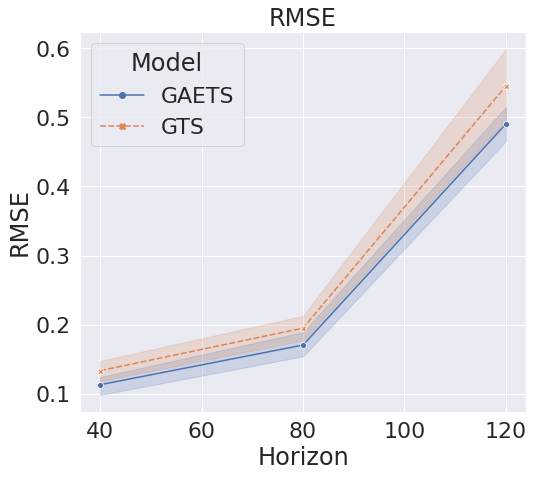

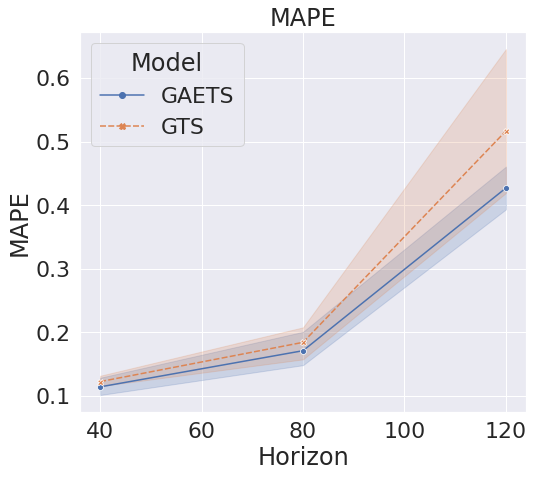

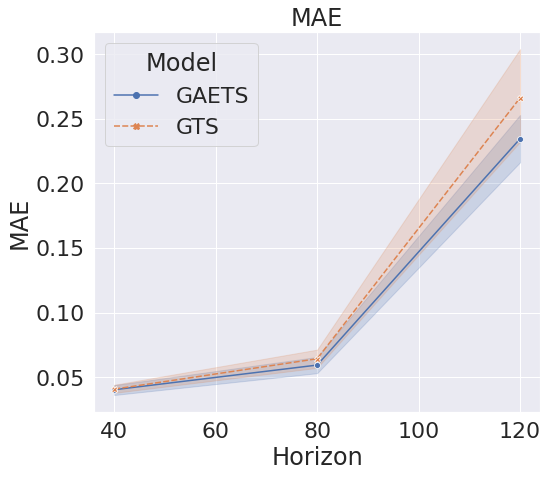

In [ ]:
for score in score_ticks:
  scoreDF = mc_scores_df.copy()
  scoreDF["Model"] = scoreDF.index
  scoreDF = scoreDF.reset_index()
  scoreDF = scoreDF[scoreDF["Model"] != "VAR"]

  sns.set(font_scale=2)

  plt.figure(figsize=(8, 7))
  plt.title(score)
  sns.lineplot(data=scoreDF, x="Horizon", y=score, hue="Model", style="Model", markers=True, dashes=True, ci=90)
  plt.show()

  print("")

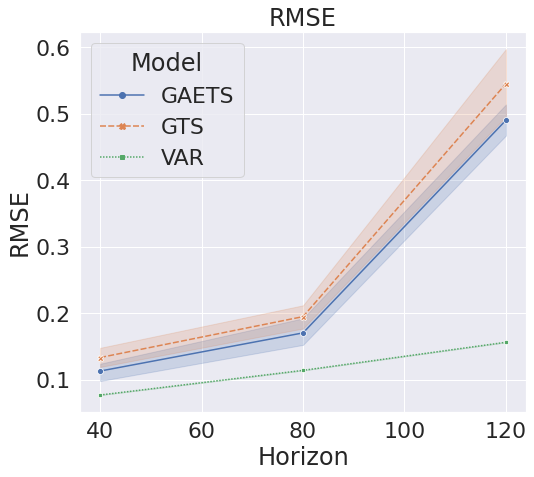

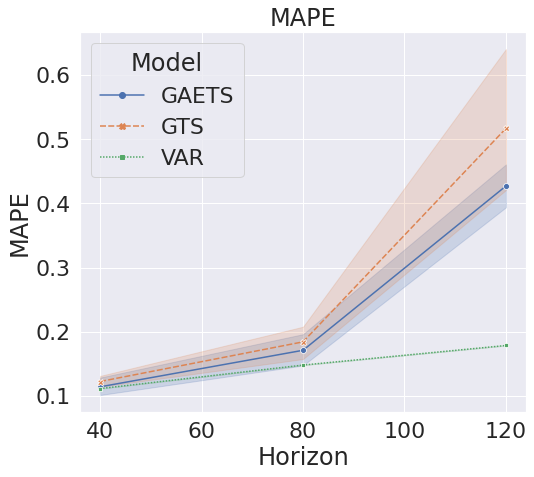

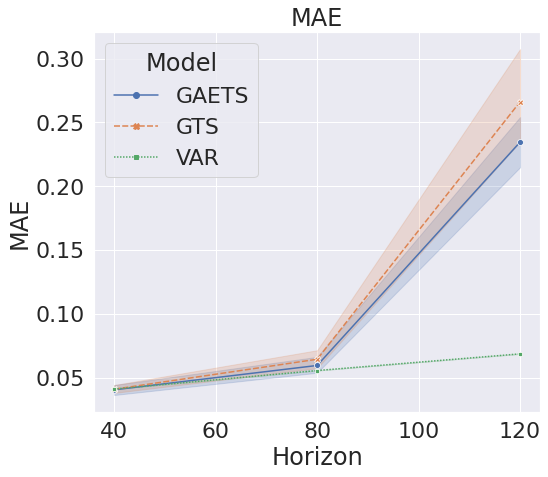

In [ ]:
for score in score_ticks:
  scoreDF = mc_scores_df.copy()
  scoreDF["Model"] = scoreDF.index
  scoreDF = scoreDF.reset_index()
  # scoreDF = scoreDF[scoreDF["Model"] != "VAR"]

  sns.set(font_scale=2)

  plt.figure(figsize=(8, 7))
  plt.title(score)
  sns.lineplot(data=scoreDF, x="Horizon", y=score, hue="Model", style="Model", markers=True, dashes=True, ci=90)
  plt.show()

  print("")

seq_len: 80, horizon: 80


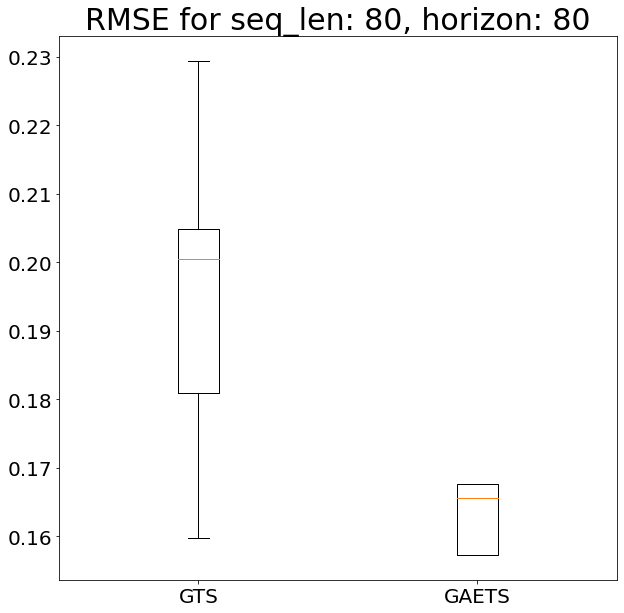

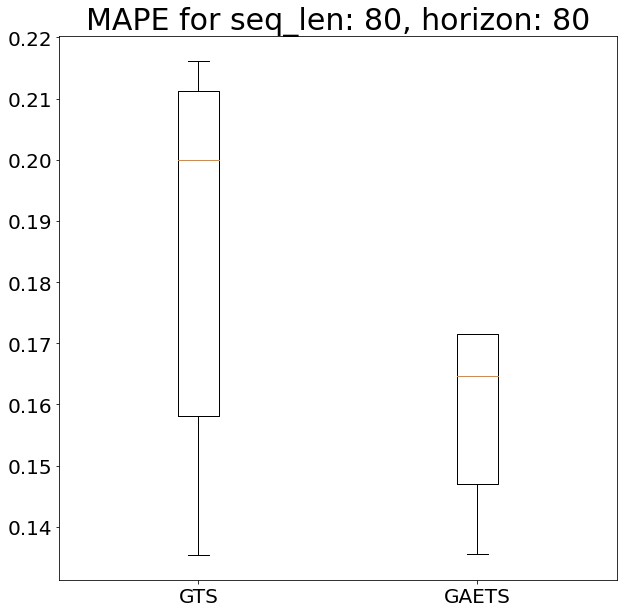

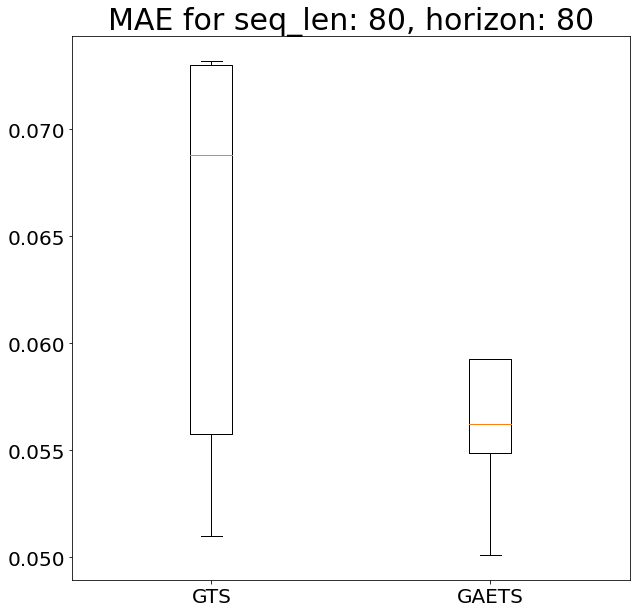


seq_len: 80, horizon: 120


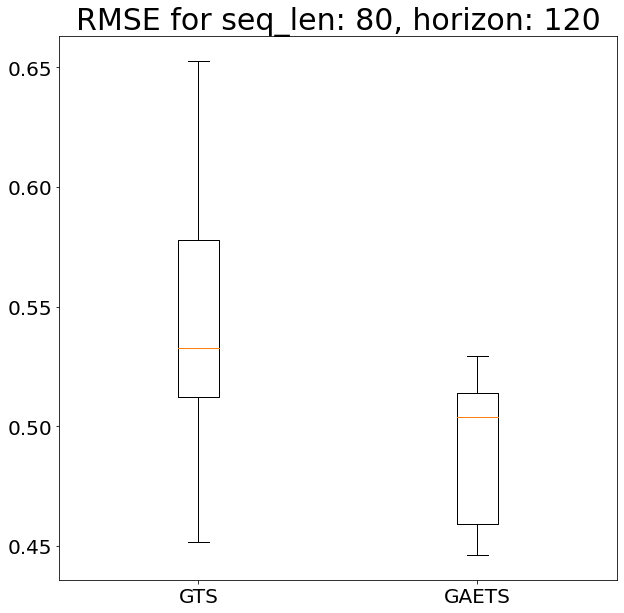

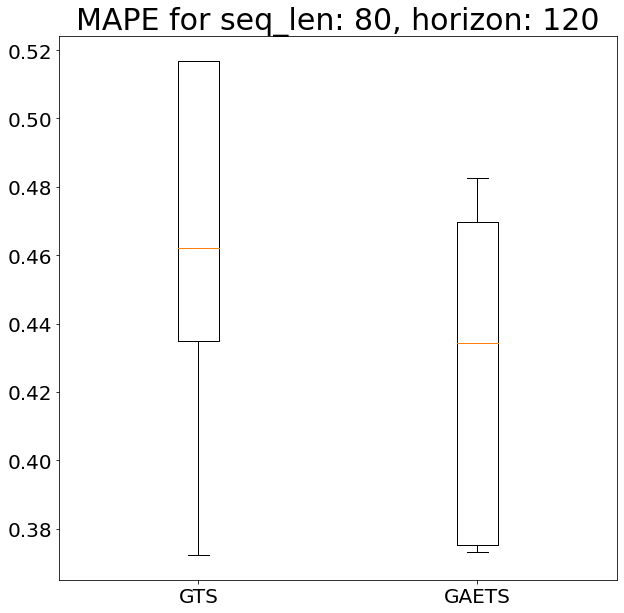

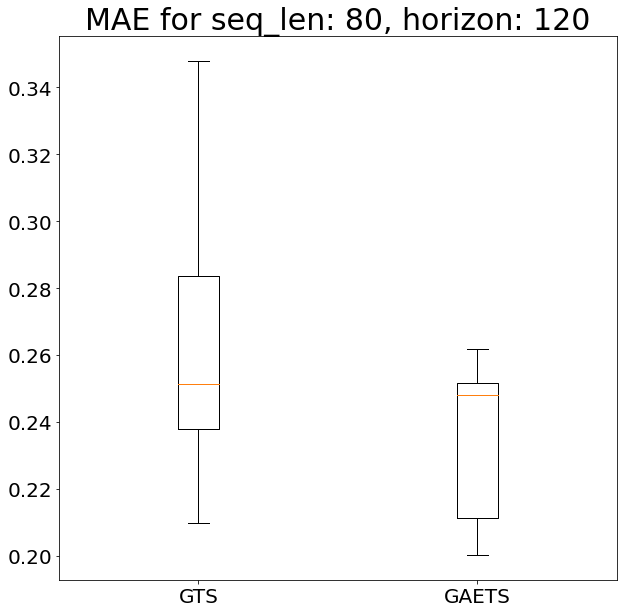


seq_len: 80, horizon: 40


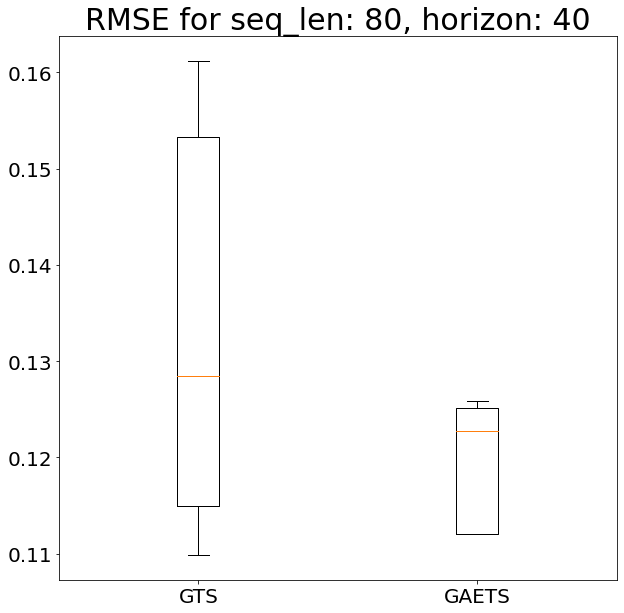

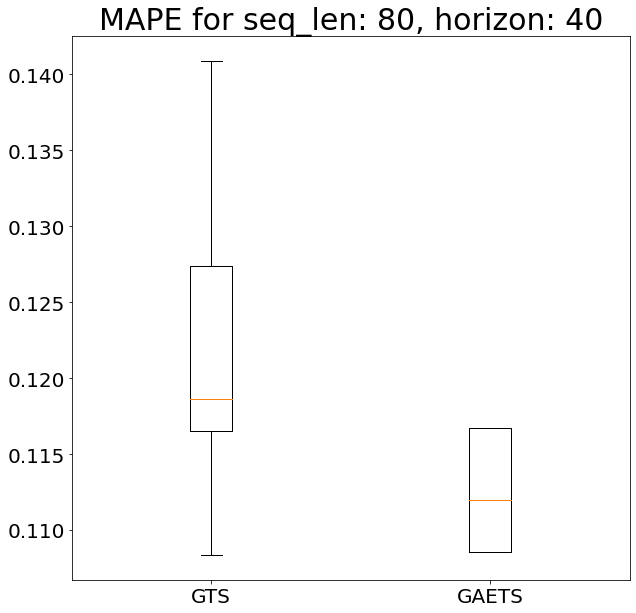

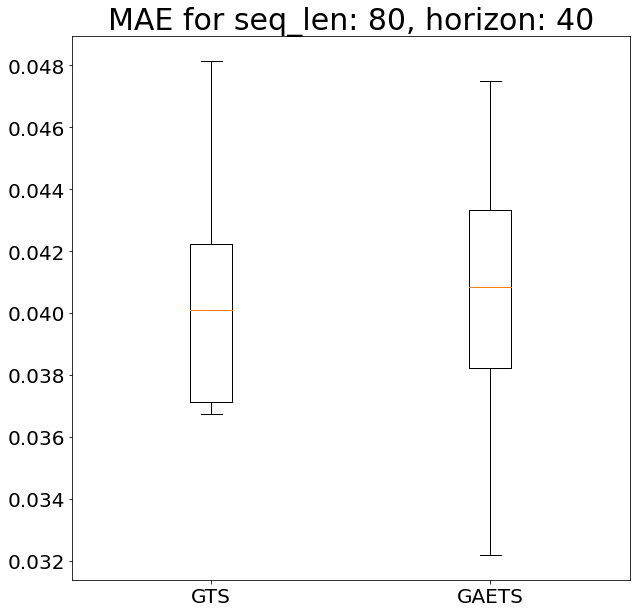

In [ ]:
""" Score Visualisation """
for seq_len in seq_lens:
  for horizon in horizons:
    print("seq_len: {}, horizon: {}".format(seq_len, horizon))
    for score_name in score_ticks:

      plt.figure(figsize=(10, 10))
      plt.title("{} for seq_len: {}, horizon: {}".format(score_name,seq_len, horizon), fontsize=30)
      scoreDF = mc_scores_df
      for i, model_name in enumerate(list_models):
        score_value = scoreDF[(scoreDF.index == model_name) & (scoreDF["Sequence Length"]==seq_len)&(scoreDF["Horizon"]==horizon)][[score_name]].values
        plt.boxplot(score_value, positions=[i], showfliers=False)
      plt.xticks(range(len(list_models)), list_models, fontsize=20)
      plt.yticks(fontsize=20)
      plt.plot()
      plt.show()

      print("")

best GTS epoch: 41 and GAETS epoch: 48
2021-09-27 16:54:46,662 - INFO - Loaded model at 41
2021-09-27 16:54:46,662 - INFO - Loaded model at 41
2021-09-27 16:54:46,662 - INFO - Loaded model at 41
2021-09-27 16:54:46,714 - INFO - Loaded model at 48
2021-09-27 16:54:46,714 - INFO - Loaded model at 48
2021-09-27 16:54:46,714 - INFO - Loaded model at 48


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0


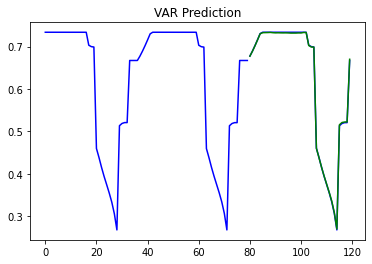

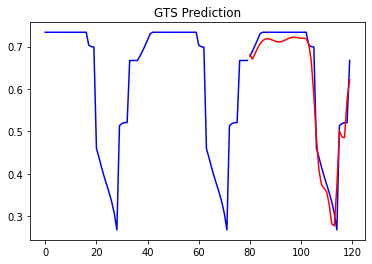

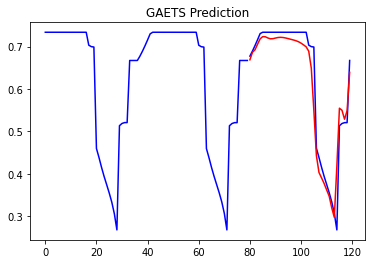

1


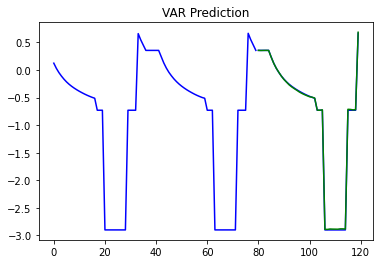

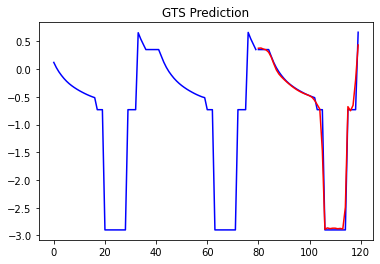

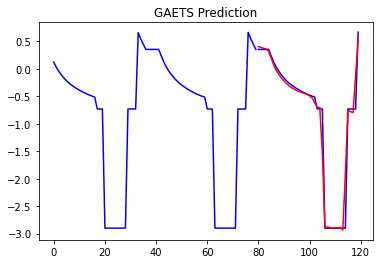

2


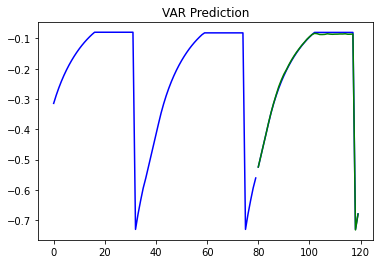

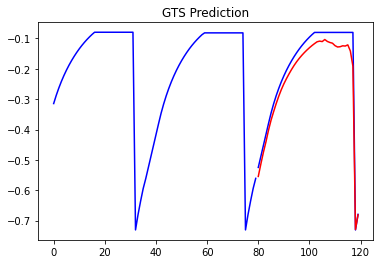

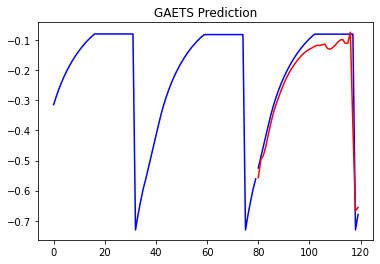

3


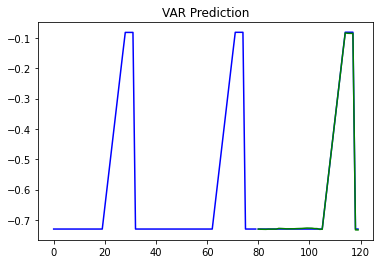

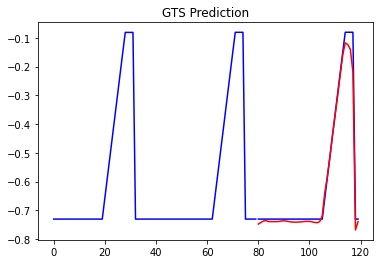

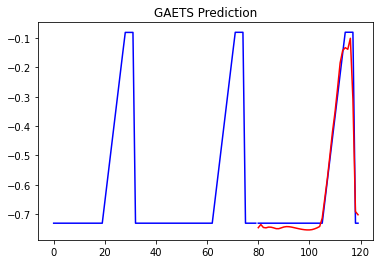

4


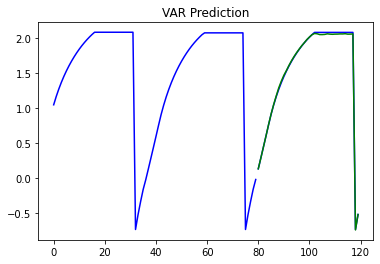

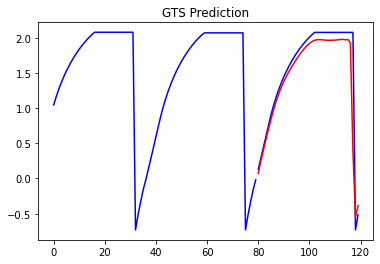

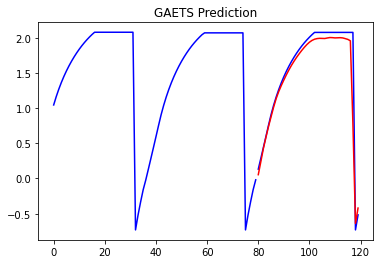

5


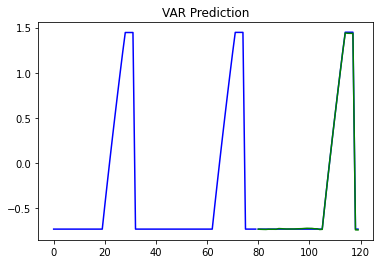

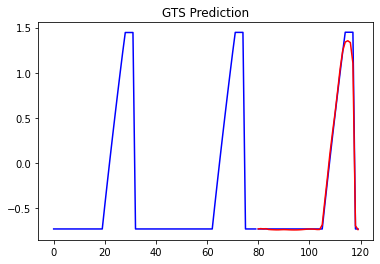

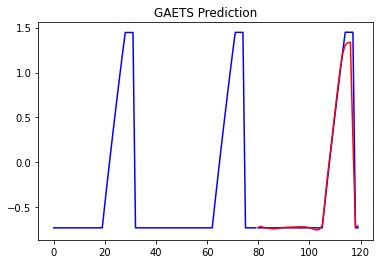

In [ ]:
# visualise result
"""
VISUALISE
"""

# get largest epoch
files = os.listdir("models/GTS")
largestGTSEpoch = max([int(re.search("epo(.+?).tar", x).group(1)) for x in files])
files = os.listdir("models/GAETS")
largestGAETSEpoch = max([int(re.search("epo(.+?).tar", x).group(1)) for x in files])
print("best GTS epoch: {} and GAETS epoch: {}".format(largestGTSEpoch, largestGAETSEpoch))

# Load Model
supervisor_gts._epoch_num = largestGTSEpoch
supervisor_gts.load_model()
supervisor_gaets._epoch_num = largestGAETSEpoch
supervisor_gaets.load_model()
label = "with_regularization"
temp_gts = supervisor_gts.temperature
temp_gaets = supervisor_gaets.temperature
gumbel_soft = True
batches_seen = 1

# get test data from unseen dataset
gts_test_iterator = create_test_iterator(supervisor_gts, supervisor_config, "data/graphbatt/test")
gaets_test_iterator = create_test_iterator(supervisor_gaets, supervisor_config, "data/graphbatt/test")

"""
COMPARE PERFORMANCE
"""
# for each batch
var_rmses = []
var_mapes = []
var_maes = []
gts_rmses = []
gts_mapes = []
gts_maes = []
gaets_rmses = []
gaets_mapes = []
gaets_maes = []

# for each batch
for batch_idx, (_x, _y) in tqdm(enumerate(gaets_test_iterator)):
  """ GAETS """
  x, y = supervisor_gaets._prepare_data(_x, _y)
  supervisor_gaets.GTS_model = supervisor_gaets.GTS_model.eval()
  output, mid_output, _train_feas_rec = supervisor_gaets.GTS_model(label, x, supervisor_gaets._train_feas, temp_gaets, gumbel_soft, y, batches_seen)
  output = output.detach()
  # for each batch
  for i in range(x.shape[1]):
    labels = y[:, i, :].cpu().numpy()
    gaets_prediction = output[:, i, :].cpu().numpy()
    gaets_rmse = masked_rmse_np(preds=gaets_prediction, labels=labels, null_val=0)
    gaets_mape = masked_mape_np(preds=gaets_prediction, labels=labels, null_val=0)
    gaets_mae = masked_mae_np(preds=gaets_prediction, labels=labels, null_val=0)

    # keep track
    if abs(gaets_rmse) < np.float("inf"):
      gaets_rmses.append(gaets_rmse)
    if abs(gaets_mape) < np.float("inf"):
      gaets_mapes.append(gaets_mape)
    if abs(gaets_mae) < np.float("inf"):
      gaets_maes.append(gaets_mae)

    # break
  break



""" GTS """
for batch_idx, (_x, _y) in tqdm(enumerate(gts_test_iterator)):
  x, y = supervisor_gts._prepare_data(_x, _y)
  supervisor_gts.GTS_model = supervisor_gts.GTS_model.eval()
  output, mid_output = supervisor_gts.GTS_model(label, x, supervisor_gts._train_feas, temp_gts, gumbel_soft, y, batches_seen)
  output = output.detach()
  # for each batch
  for i in range(x.shape[1]):
    labels = y[:, i, :].cpu().numpy()
    gts_prediction = output[:, i, :].cpu().numpy()
    gts_rmse = masked_rmse_np(preds=gts_prediction, labels=labels, null_val=0)
    gts_mape = masked_mape_np(preds=gts_prediction, labels=labels, null_val=0)
    gts_mae = masked_mae_np(preds=gts_prediction, labels=labels, null_val=0)

    # keep track
    if abs(gts_rmse) < np.float("inf"):
      gts_rmses.append(gts_rmse)
    if abs(gts_mape) < np.float("inf"):
      gts_mapes.append(gts_mape)
    if abs(gts_mae) < np.float("inf"):
      gts_maes.append(gts_mae)

    # break

  """ VAR """
  # for each batch
  for i in range(x.shape[1]):
    labels = y[:, i, :].cpu().numpy()
    input = x[:, i, :].cpu().numpy()

    # fit VAR model on input
    var_model = VAR(input)
    # TODO: choose best lag
    var_result = var_model.fit(31)
    var_prediction = var_result.forecast(input, 40)

    var_rmse = masked_rmse_np(preds=var_prediction, labels=labels, null_val=0)
    var_mape = masked_mape_np(preds=var_prediction, labels=labels, null_val=0)
    var_mae = masked_mae_np(preds=var_prediction, labels=labels, null_val=0)

    # keep track
    if abs(var_rmse) < np.float("inf"):
      var_rmses.append(var_rmse)
    if abs(var_mape) < np.float("inf"):
      var_mapes.append(var_mape)
    if abs(var_mae) < np.float("inf"):
      var_maes.append(var_mae)

    # break
  break

# for each measurement
for i in range(6):

  print(i)

  plt.title("VAR Prediction")
  plt.plot(range(input.shape[0]), input[:, i], c="b")
  plt.plot(range(input.shape[0], input.shape[0] + labels.shape[0]), labels[:, i], c="b")
  plt.plot(range(input.shape[0], input.shape[0] + labels.shape[0]), var_prediction[:, i], c="g")
  plt.show()

  plt.title("GTS Prediction")
  plt.plot(range(input.shape[0]), input[:, i], c="b")
  plt.plot(range(input.shape[0], input.shape[0] + labels.shape[0]), labels[:, i], c="b")
  plt.plot(range(input.shape[0], input.shape[0] + labels.shape[0]), gts_prediction[:, i], c="r")
  plt.show()

  plt.title("GAETS Prediction")
  plt.plot(range(input.shape[0]), input[:, i], c="b")
  plt.plot(range(input.shape[0], input.shape[0] + labels.shape[0]), labels[:, i], c="b")
  plt.plot(range(input.shape[0], input.shape[0] + labels.shape[0]), gaets_prediction[:, i], c="r")
  plt.show()

## debug visualise

Generating training data
x shape:  (2058, 80, 6, 1) , y shape:  (2058, 120, 6, 1)
train x:  (1441, 80, 6, 1) y: (1441, 120, 6, 1)
val x:  (205, 80, 6, 1) y: (205, 120, 6, 1)
test x:  (412, 80, 6, 1) y: (412, 120, 6, 1)
Generating training data
x shape:  (2058, 80, 6, 1) , y shape:  (2058, 120, 6, 1)
train x:  (412, 80, 6, 1) y: (412, 120, 6, 1)
val x:  (205, 80, 6, 1) y: (205, 120, 6, 1)
test x:  (1441, 80, 6, 1) y: (1441, 120, 6, 1)
2021-10-05 12:23:30,568 - INFO - Log directory: data/model/GAETS_DR_2_h_120_64_lr_0.005_bs_64_1005122330/
2021-10-05 12:23:30,568 - INFO - Log directory: data/model/GAETS_DR_2_h_120_64_lr_0.005_bs_64_1005122330/
2021-10-05 12:23:30,568 - INFO - Log directory: data/model/GAETS_DR_2_h_120_64_lr_0.005_bs_64_1005122330/
2021-10-05 12:23:30,705 - INFO - Model created
2021-10-05 12:23:30,705 - INFO - Model created
2021-10-05 12:23:30,705 - INFO - Model created


2021-10-05 12:23:37,573 - INFO - Start training ...
2021-10-05 12:23:37,573 - INFO - Start training ...
2021-10-05 12:23:37,573 - INFO - Start training ...
2021-10-05 12:23:37,588 - INFO - num_batches:23
2021-10-05 12:23:37,588 - INFO - num_batches:23
2021-10-05 12:23:37,588 - INFO - num_batches:23
Num of epoch: 0
2021-10-05 12:23:37,819 - INFO - Total trainable parameters 3072347
2021-10-05 12:23:37,819 - INFO - Total trainable parameters 3072347
2021-10-05 12:23:37,819 - INFO - Total trainable parameters 3072347
2021-10-05 12:23:46,653 - INFO - epoch complete
2021-10-05 12:23:46,653 - INFO - epoch complete
2021-10-05 12:23:46,653 - INFO - epoch complete
2021-10-05 12:23:46,659 - INFO - evaluating now!
2021-10-05 12:23:46,659 - INFO - evaluating now!
2021-10-05 12:23:46,659 - INFO - evaluating now!


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


2021-10-05 12:23:47,308 - INFO - Epoch [0/200] (23) train_mae: 3.8855, val_mae: 3.1724
2021-10-05 12:23:47,308 - INFO - Epoch [0/200] (23) train_mae: 3.8855, val_mae: 3.1724
2021-10-05 12:23:47,308 - INFO - Epoch [0/200] (23) train_mae: 3.8855, val_mae: 3.1724
2021-10-05 12:23:47,367 - INFO - Saved model at 0
2021-10-05 12:23:47,367 - INFO - Saved model at 0
2021-10-05 12:23:47,367 - INFO - Saved model at 0
2021-10-05 12:23:47,378 - INFO - Val loss decrease from inf to 3.1724, saving to models/GAETS/epo0.tar
2021-10-05 12:23:47,378 - INFO - Val loss decrease from inf to 3.1724, saving to models/GAETS/epo0.tar
2021-10-05 12:23:47,378 - INFO - Val loss decrease from inf to 3.1724, saving to models/GAETS/epo0.tar
Num of epoch: 1
2021-10-05 12:23:56,398 - INFO - epoch complete
2021-10-05 12:23:56,398 - INFO - epoch complete
2021-10-05 12:23:56,398 - INFO - epoch complete
2021-10-05 12:23:56,409 - INFO - evaluating now!
2021-10-05 12:23:56,409 - INFO - evaluating now!
2021-10-05 12:23:56,40

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


2021-10-05 12:24:31,713 - INFO - Saved model at 4
2021-10-05 12:24:31,713 - INFO - Saved model at 4
2021-10-05 12:24:31,713 - INFO - Saved model at 4
2021-10-05 12:24:31,724 - INFO - Val loss decrease from 1.8411 to 1.6696, saving to models/GAETS/epo4.tar
2021-10-05 12:24:31,724 - INFO - Val loss decrease from 1.8411 to 1.6696, saving to models/GAETS/epo4.tar
2021-10-05 12:24:31,724 - INFO - Val loss decrease from 1.8411 to 1.6696, saving to models/GAETS/epo4.tar
Num of epoch: 5
2021-10-05 12:24:40,761 - INFO - epoch complete
2021-10-05 12:24:40,761 - INFO - epoch complete
2021-10-05 12:24:40,761 - INFO - epoch complete
2021-10-05 12:24:40,770 - INFO - evaluating now!
2021-10-05 12:24:40,770 - INFO - evaluating now!
2021-10-05 12:24:40,770 - INFO - evaluating now!
2021-10-05 12:24:41,423 - INFO - Epoch [5/200] (138) train_mae: 1.9421, val_mae: 1.9777
2021-10-05 12:24:41,423 - INFO - Epoch [5/200] (138) train_mae: 1.9421, val_mae: 1.9777
2021-10-05 12:24:41,423 - INFO - Epoch [5/200] (1

testing loss,█▆▅▅▄▄▄▄▄▄▄▄▄▄▃▁▁▂▁▂▁▁▁▁▂▁▂▂▁▁▂▂▁▁▂▂▁
training loss,█▆▅▃▃▃▃▃▃▃▂▃▂▂▂▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation loss,█▆▄▃▃▃▂▃▂▂▂▂▂▂▂▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
testing loss,0.29063
training loss,0.14782
validation loss,0.25221


best GTS epoch: 130 and GAETS epoch: 84
2021-10-05 12:53:59,700 - INFO - Loaded model at 130
2021-10-05 12:53:59,700 - INFO - Loaded model at 130
2021-10-05 12:53:59,700 - INFO - Loaded model at 130
2021-10-05 12:53:59,740 - INFO - Loaded model at 84
2021-10-05 12:53:59,740 - INFO - Loaded model at 84
2021-10-05 12:53:59,740 - INFO - Loaded model at 84


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0


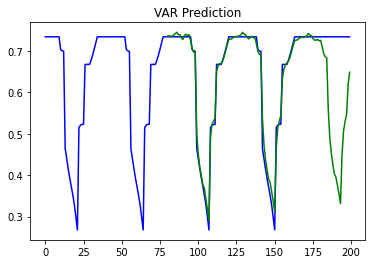

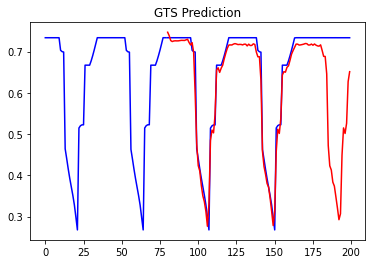

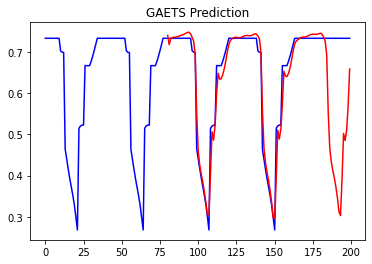

1


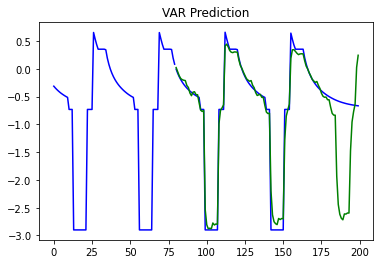

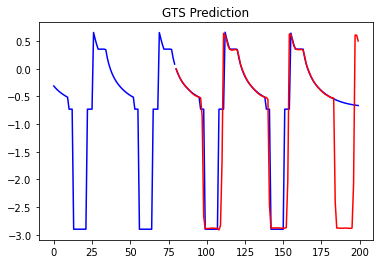

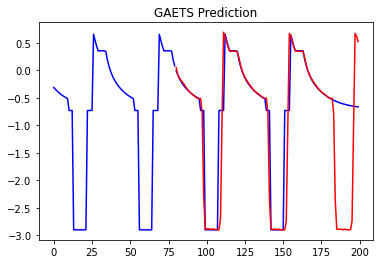

2


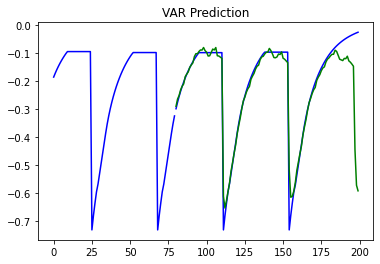

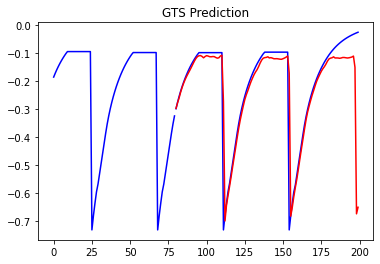

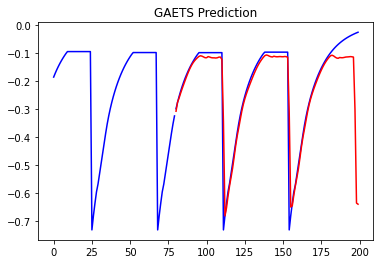

3


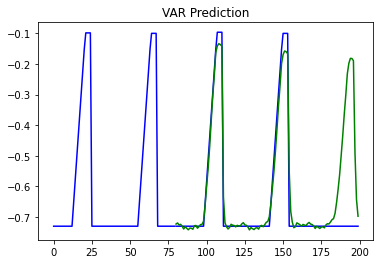

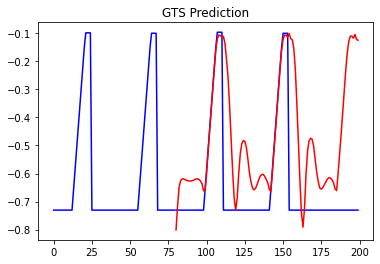

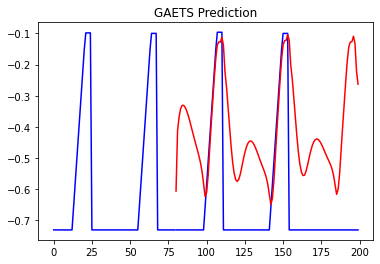

4


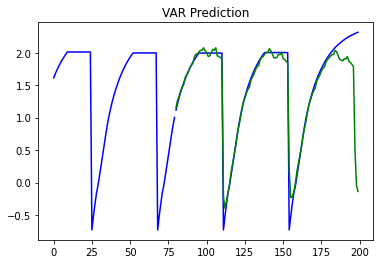

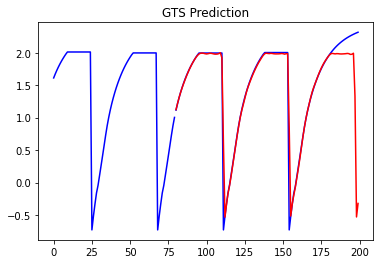

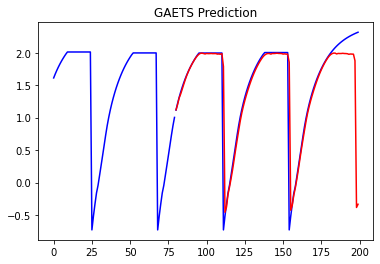

5


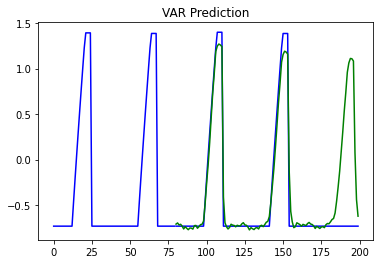

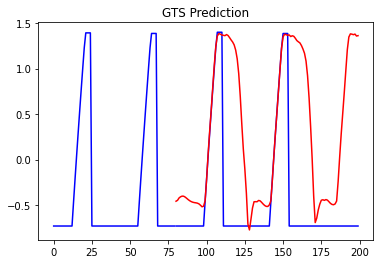

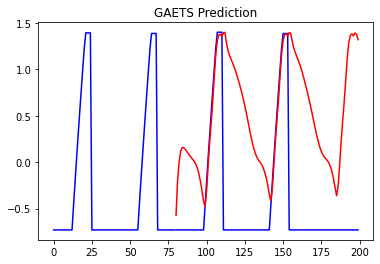

{'GAETS': {'Best Epoch': 84,
  'Horizon': 120,
  'MAE': 0.2514487,
  'MAE data points': 1472,
  'MAPE': 0.43336654,
  'MAPE data points': 1472,
  'RMS data points': 1472,
  'RMSE': 0.5571847,
  'Sequence Length': 80},
 'GTS': {'Best Epoch': 130,
  'Horizon': 120,
  'MAE': 0.21362798,
  'MAE data points': 1472,
  'MAPE': 0.3641283,
  'MAPE data points': 1472,
  'RMS data points': 1472,
  'RMSE': 0.53237057,
  'Sequence Length': 80},
 'VAR': {'Best Epoch': -1,
  'Horizon': 120,
  'MAE': 0.06858496,
  'MAE data points': 1472,
  'MAPE': 0.17851695,
  'MAPE data points': 1472,
  'RMS data points': 1472,
  'RMSE': 0.15651351,
  'Sequence Length': 80}}

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seq_len = 80
horizon = 120

!python -m scripts.generate_training_data_customWindow --output_dir=data/graphbatt/train --traffic_df_filename=data/graphbatt/DOE-001-050-10DU_05_Channel_81_1.h5 --seq_len=$seq_len --horizon=$horizon --train_size=0.7 --test_size=0.2
!python -m scripts.generate_training_data_customWindow --output_dir=data/graphbatt/test --traffic_df_filename=data/graphbatt/DOE-001-050-10DU_05_Channel_82_1.h5 --seq_len=$seq_len --horizon=$horizon --train_size=0.2 --test_size=0.7

# load model and test dataset
args = DummyTrainArgs(config_filename="data/model/para_graphbatt.yaml", use_cpu_only=False, temperature=0.5)
with open(args.config_filename) as f:
    supervisor_config = yaml.load(f)

    # modify seq_len and horizon
    supervisor_config["model"]["horizon"] = horizon
    supervisor_config["model"]["seq_len"] = seq_len
    supervisor_config["train"]["epochs"] = 200
    save_adj_name = args.config_filename[11:-5]
    # train gaets
    supervisor_gaets = GAETSSupervisor(save_adj_name, temperature=args.temperature, **supervisor_config)
    supervisor_gaets.GTS_model.use_curriculum_learning = False
    supervisor_gaets.train()

    # train gts
    supervisor_config["train"]["epochs"] = 200
    supervisor_gts = GTSSupervisor(save_adj_name, temperature=args.temperature, **supervisor_config)
    supervisor_gts.GTS_model.use_curriculum_learning = False
    supervisor_gts.train()
    # train var
    scaler = supervisor_gts.train_scaler
    data = scaler.transform(train_df[["Voltage(V)", "Current(A)", "Charge_Capacity(Ah)", "Discharge_Capacity(Ah)", "Charge_Energy(Wh)", "Discharge_Energy(Wh)"]].values)
    var_model = VAR(data)
    # TODO: choose best lag
    var_result = var_model.fit(31)



# get largest epoch
files = os.listdir("models/GTS")
largestGTSEpoch = max([int(re.search("epo(.+?).tar", x).group(1)) for x in files])
files = os.listdir("models/GAETS")
largestGAETSEpoch = max([int(re.search("epo(.+?).tar", x).group(1)) for x in files])
print("best GTS epoch: {} and GAETS epoch: {}".format(largestGTSEpoch, largestGAETSEpoch))

# Load Model
supervisor_gts._epoch_num = largestGTSEpoch
supervisor_gts.load_model()
supervisor_gaets._epoch_num = largestGAETSEpoch
supervisor_gaets.load_model()
label = "with_regularization"
temp_gts = supervisor_gts.temperature
temp_gaets = supervisor_gaets.temperature
gumbel_soft = True
batches_seen = 1

# # get test data from unseen dataset
gts_test_iterator = create_test_iterator(supervisor_gts, supervisor_config, "data/graphbatt/test")
gaets_test_iterator = create_test_iterator(supervisor_gaets, supervisor_config, "data/graphbatt/test")

"""
COMPARE PERFORMANCE
"""
# for each batch
var_rmses = []
var_mapes = []
var_maes = []
gts_rmses = []
gts_mapes = []
gts_maes = []
gaets_rmses = []
gaets_mapes = []
gaets_maes = []

# for each batch
for batch_idx, (_x, _y) in tqdm(enumerate(gaets_test_iterator)):
  """ GAETS """
  x, y = supervisor_gaets._prepare_data(_x, _y)
  # supervisor_gaets.GTS_model = supervisor_gaets.GTS_model.train()
  supervisor_gaets.GTS_model = supervisor_gaets.GTS_model.eval()
  output, mid_output, _train_feas_rec = supervisor_gaets.GTS_model(label, x, supervisor_gaets._train_feas, temp_gaets, gumbel_soft, y, batches_seen)
  output = output.detach()
  # for each batch
  for i in range(x.shape[1]):
    labels = y[:, i, :].cpu().numpy()
    gaets_prediction = output[:, i, :].cpu().numpy()
    gaets_rmse = masked_rmse_np(preds=gaets_prediction, labels=labels, null_val=0)
    gaets_mape = masked_mape_np(preds=gaets_prediction, labels=labels, null_val=0)
    gaets_mae = masked_mae_np(preds=gaets_prediction, labels=labels, null_val=0)

    # keep track
    if abs(gaets_rmse) < np.float("inf"):
      gaets_rmses.append(gaets_rmse)
    if abs(gaets_mape) < np.float("inf"):
      gaets_mapes.append(gaets_mape)
    if abs(gaets_mae) < np.float("inf"):
      gaets_maes.append(gaets_mae)

  """ VAR """
  # for each batch
  for i in range(x.shape[1]):
    labels = y[:, i, :].cpu().numpy()
    input = x[:, i, :].cpu().numpy()

    # predict
    var_prediction = var_result.forecast(input, horizon)

    var_rmse = masked_rmse_np(preds=var_prediction, labels=labels, null_val=0)
    var_mape = masked_mape_np(preds=var_prediction, labels=labels, null_val=0)
    var_mae = masked_mae_np(preds=var_prediction, labels=labels, null_val=0)

    # keep track
    if abs(var_rmse) < np.float("inf"):
      var_rmses.append(var_rmse)
    if abs(var_mape) < np.float("inf"):
      var_mapes.append(var_mape)
    if abs(var_mae) < np.float("inf"):
      var_maes.append(var_mae)


""" GTS """
for batch_idx, (_x, _y) in tqdm(enumerate(gts_test_iterator)):
  x, y = supervisor_gts._prepare_data(_x, _y)
  # supervisor_gts.GTS_model = supervisor_gts.GTS_model.train()
  supervisor_gts.GTS_model = supervisor_gts.GTS_model.eval()
  output, mid_output = supervisor_gts.GTS_model(label, x, supervisor_gts._train_feas, temp_gts, gumbel_soft, y, batches_seen)
  output = output.detach()
  # for each batch
  for i in range(x.shape[1]):
    labels = y[:, i, :].cpu().numpy()
    gts_prediction = output[:, i, :].cpu().numpy()
    gts_rmse = masked_rmse_np(preds=gts_prediction, labels=labels, null_val=0)
    gts_mape = masked_mape_np(preds=gts_prediction, labels=labels, null_val=0)
    gts_mae = masked_mae_np(preds=gts_prediction, labels=labels, null_val=0)

    # keep track
    if abs(gts_rmse) < np.float("inf"):
      gts_rmses.append(gts_rmse)
    if abs(gts_mape) < np.float("inf"):
      gts_mapes.append(gts_mape)
    if abs(gts_mae) < np.float("inf"):
      gts_maes.append(gts_mae)


"""
get score
"""
scoreMedianDict = {
  "GAETS": {
      "RMSE": np.median(gaets_rmses), 
      "MAPE": np.median(gaets_mapes), 
      "MAE": np.median(gaets_maes), 
      "RMS data points": len(gaets_rmses), 
      "MAPE data points": len(gaets_mapes), 
      "MAE data points": len(gaets_maes),
      "Best Epoch": largestGAETSEpoch,
      "Sequence Length": seq_len,
      "Horizon": horizon
  },
  "GTS": {
      "RMSE": np.median(gts_rmses), 
      "MAPE": np.median(gts_mapes), 
      "MAE": np.median(gts_maes), 
      "RMS data points": len(gts_rmses), 
      "MAPE data points": len(gts_mapes), 
      "MAE data points": len(gts_maes),
      "Best Epoch": largestGTSEpoch,
      "Sequence Length": seq_len,
      "Horizon": horizon
  },
  "VAR": {
      "RMSE": np.median(var_rmses), 
      "MAPE": np.median(var_mapes), 
      "MAE": np.median(var_maes), 
      "RMS data points": len(var_rmses), 
      "MAPE data points": len(var_mapes), 
      "MAE data points": len(var_maes),
      "Best Epoch": -1,
      "Sequence Length": seq_len,
      "Horizon": horizon
  },
}



# for each measurement
for i in range(6):

  print(i)

  plt.title("VAR Prediction")
  plt.plot(range(input.shape[0]), input[:, i], c="b")
  plt.plot(range(input.shape[0], input.shape[0] + labels.shape[0]), labels[:, i], c="b")
  plt.plot(range(input.shape[0], input.shape[0] + labels.shape[0]), var_prediction[:, i], c="g")
  plt.show()

  plt.title("GTS Prediction")
  plt.plot(range(input.shape[0]), input[:, i], c="b")
  plt.plot(range(input.shape[0], input.shape[0] + labels.shape[0]), labels[:, i], c="b")
  plt.plot(range(input.shape[0], input.shape[0] + labels.shape[0]), gts_prediction[:, i], c="r")
  plt.show()

  plt.title("GAETS Prediction")
  plt.plot(range(input.shape[0]), input[:, i], c="b")
  plt.plot(range(input.shape[0], input.shape[0] + labels.shape[0]), labels[:, i], c="b")
  plt.plot(range(input.shape[0], input.shape[0] + labels.shape[0]), gaets_prediction[:, i], c="r")
  plt.show()

scoreMedianDict

In [ ]:
# test_df[["Voltage(V)", "Current(A)", "Charge_Capacity(Ah)", "Discharge_Capacity(Ah)", "Charge_Energy(Wh)", "Discharge_Energy(Wh)"]].to_hdf("data/graphbatt/DOE-001-050-10DU_05_Channel_82_1.h5", key="df")
